In [1]:
import numpy as np
import copy
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gym
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

In [2]:
class LinearLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear_layer = nn.Sequential(nn.Linear(in_features, out_features), nn.ReLU())
    def forward(self, x):
        x = self.linear_layer(x)
        return x

In [3]:
class Actor(nn.Module):
    def __init__(self, s_dim, a_dim, hidden_dim=256, num_hidden_layers=2):
        super(Actor, self).__init__()

        self.s_dim = s_dim
        self.a_dim = a_dim

        layers = [LinearLayer(s_dim, hidden_dim)]
        for _ in range(num_hidden_layers):
            layers.append(LinearLayer(hidden_dim, hidden_dim))
        layers.append(nn.Linear(hidden_dim, a_dim))

        self.f = nn.Sequential(*layers)

    def forward(self, state):
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float32)
        out = self.f(state)
        #out = torch.tanh(out)
        out= F.softmax(out+1e-10, dim=-1)
        return out


In [4]:
class QDNN(nn.Module):
    def __init__(self, s_dim, a_dim, hidden_dim=256, num_hidden_layers=2):
        super(QDNN, self).__init__()

        self.s_dim = s_dim
        self.a_dim = a_dim

        layers = [LinearLayer(s_dim + a_dim, hidden_dim)]
        for _ in range(num_hidden_layers):
            layers.append(LinearLayer(hidden_dim, hidden_dim))
        layers.append(nn.Linear(hidden_dim, 1))

        self.f = nn.Sequential(*layers)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        out = self.f(x)
        return out

In [5]:
class Critic(nn.Module):
    def __init__(self, s_dim, a_dim, hidden_dim=256, num_hidden_layers=2):
        super(Critic, self).__init__()

        self.s_dim = s_dim
        self.a_dim = a_dim

        # Two DNNs to mitigate positive bias
        self.Q1 = QDNN(s_dim, a_dim, hidden_dim, num_hidden_layers)
        self.Q2 = QDNN(s_dim, a_dim, hidden_dim, num_hidden_layers)

    def forward(self, state, action):
        q1 = self.Q1(state, action)
        q2 = self.Q2(state, action)
        return q1, q2

In [6]:
class SAC():
    def __init__(self, s_dim, a_dim, hidden_dim_actor=256, hidden_dim_critic=256, 
                 num_layer_actor=2, num_layer_critic=2, lr_act=3e-4, lr_crit=3e-4, 
                 gamma=0.99, tau=0.005, alpha=0.2, lambd=0.005, target_upd_inter=1, 
                 buffer_capacity=1000, batch_size=32, grad_steps = 1, device="cpu"):
        
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.device = device
        self.batch_size = batch_size
        self.buffer = deque(maxlen=buffer_capacity)
        self.grad_steps = grad_steps

        self.alpha = alpha
        self.lambd = lambd
        self.gamma = gamma
        self.tau = tau
        self.target_upd_inter = target_upd_inter

        self.actor = Actor(s_dim, a_dim, hidden_dim_actor, num_hidden_layers=num_layer_actor).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr_act)

        self.critic = Critic(s_dim, a_dim, hidden_dim_critic, num_hidden_layers=num_layer_critic).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=lr_crit)

        # Stabilize training
        self.critic_target = copy.deepcopy(self.critic).to(device)

    def choose_action(self, state):
        self.actor.eval()
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            action_probs = self.actor(state.to(self.device))
            dist = Categorical(action_probs)
            action = dist.sample()
        return action.item(), action_probs.squeeze().detach().cpu().numpy()

    def train(self, update_interval):
        if len(self.buffer) < self.batch_size:
            return

        for i in range(self.grad_steps):
            batch = random.sample(self.buffer, self.batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)
            states = torch.tensor(states, dtype=torch.float32).to(self.device)
            actions = torch.tensor(actions, dtype=torch.float32).squeeze().to(self.device)
            rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
            next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
            dones = torch.tensor(dones, dtype=torch.float32).to(self.device)
            #print(dones)
            
            # Critic train
            self.critic.train()
            
            with torch.no_grad():
                probs = self.actor(next_states)
                dist = Categorical(probs)
                sampled_actions = dist.sample()
                next_actions_log_probs = dist.log_prob(sampled_actions).unsqueeze(1)
                q1_next, q2_next = self.critic_target(next_states, probs)
                min_q_next = torch.min(q1_next, q2_next)
                #print((torch.ones_like(dones)-dones).shape)
                target_q_value = rewards + self.gamma *(torch.ones_like(dones)-dones).unsqueeze(1)*(min_q_next - self.alpha * next_actions_log_probs)#.sum(-1, keepdim=True))
                
            q1, q2 = self.critic(states, actions)
            
            critic_loss = F.mse_loss(q1, target_q_value.detach()) + F.mse_loss(q2, target_q_value.detach())

            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Actor train
            self.actor.train()

            probs = self.actor(states)
            dist = Categorical(probs)
            sampled_actions = dist.sample()
            log_probs = dist.log_prob(sampled_actions)#.sum(-1, keepdim=True)
            q1_actor, q2_actor = self.critic(states, probs)
            min_q_actor = torch.min(q1_actor, q2_actor)
            
            actor_loss = (self.alpha * log_probs.unsqueeze(1) - min_q_actor).mean()

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Soft update of target networks
            if update_interval % self.target_upd_inter == 0:
                for target_parameters, parameters in zip(self.critic_target.parameters(), self.critic.parameters()):
                    target_parameters.data.copy_(self.tau * parameters.data + (1.0 - self.tau) * target_parameters.data)

        #print(critic_loss.item(), actor_loss.item())
        return critic_loss.item(), actor_loss.item()

    def add_elements_to_buffer(self, state, probs, reward, next_state, done):
        self.buffer.append((state, probs, reward, next_state, done))

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Cartpole

episode 0 score 17.0 avg score 17.0
episode 1 score 15.0 avg score 16.0
episode 2 score 11.0 avg score 14.3
episode 3 score 15.0 avg score 14.5
episode 4 score 15.0 avg score 14.6
episode 5 score 11.0 avg score 14.0
episode 6 score 12.0 avg score 13.7
episode 7 score 13.0 avg score 13.6
episode 8 score 9.0 avg score 13.1
episode 9 score 11.0 avg score 12.9
episode 10 score 10.0 avg score 12.6
episode 11 score 10.0 avg score 12.4
episode 12 score 9.0 avg score 12.2
episode 13 score 9.0 avg score 11.9
episode 14 score 8.0 avg score 11.7
episode 15 score 11.0 avg score 11.6
episode 16 score 40.0 avg score 13.3
episode 17 score 34.0 avg score 14.4
episode 18 score 36.0 avg score 15.6
episode 19 score 110.0 avg score 20.3
episode 20 score 58.0 avg score 22.1
episode 21 score 33.0 avg score 22.6
episode 22 score 31.0 avg score 23.0
episode 23 score 47.0 avg score 24.0
episode 24 score 125.0 avg score 28.0
episode 25 score 200.0 avg score 34.6
episode 26 score 195.0 avg score 40.6
episode 27 

ValueError: x and y must have same first dimension, but have shapes (201,) and (200,)

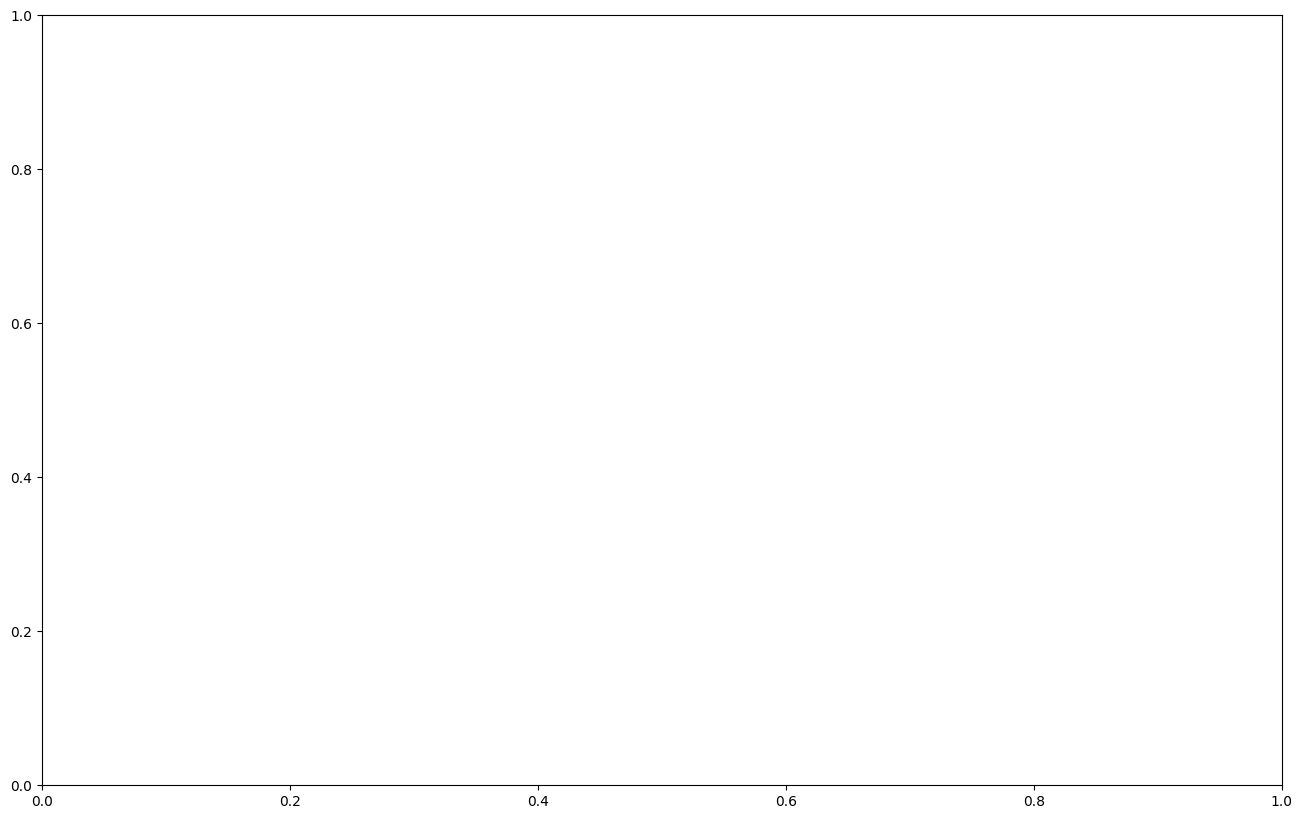

In [29]:
env = gym.make('CartPole-v0')
env.seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
n_games = 300
agent = SAC(state_dim, action_dim, buffer_capacity=int(1e6), hidden_dim_actor = 128, hidden_dim_critic=128, 
            num_layer_actor=2, num_layer_critic=2, lr_act=6e-4, lr_crit=6e-4, alpha=0.2, tau=0.05, batch_size=20, 
            grad_steps=2, device=device)

figure_file = 'plots/cartpoleV0.png'

best_score = env.reward_range[0]
score_history = []

learn_iters = 0
avg_score = 0
n_steps = 0
training_interval=1
update_interval = 1


for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0
    while not done:
        action, probs = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        agent.add_elements_to_buffer(observation, probs, reward, observation_, done)
        observation = observation_
        update_interval += 1
        n_steps += 1
        if n_steps % training_interval == 0:
            agent.train(update_interval)

    score_history.append(score)
    avg_score = np.mean(score_history[-100:])
    print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score)

x = [i+1 for i in range(len(score_history))]
plot_learning_curve(x[:-1], score_history, figure_file)

NameError: name 'scores' is not defined

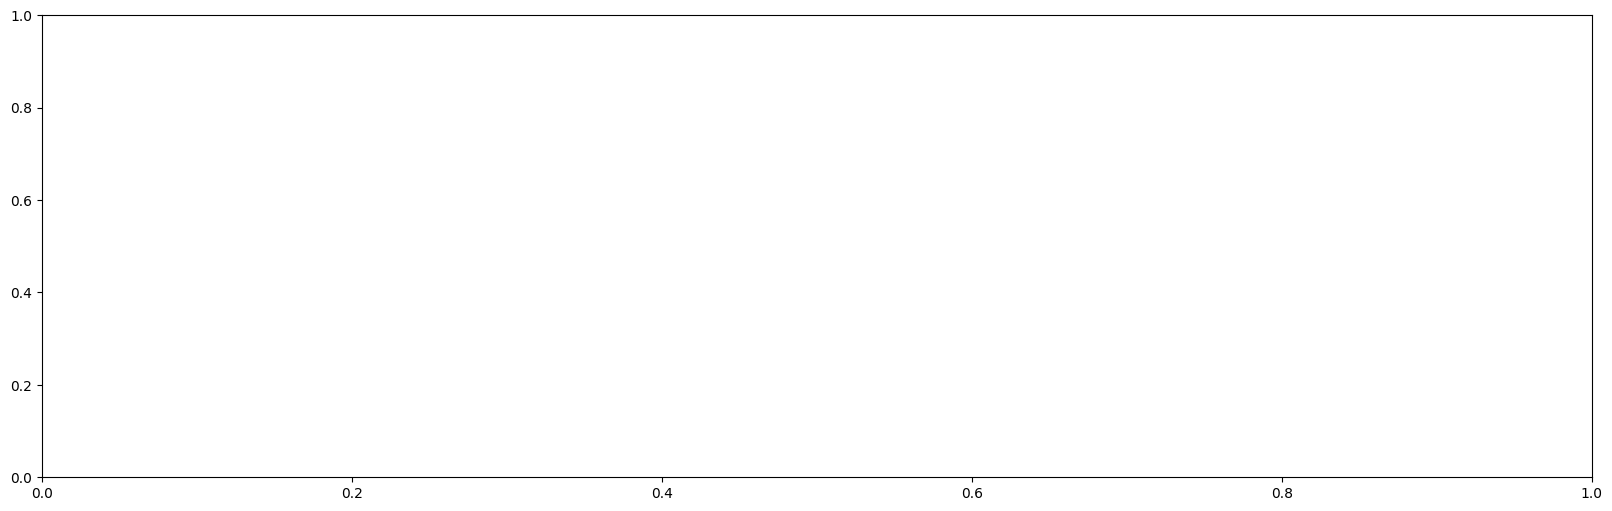

In [13]:
### Plot the learning progress

# Create the plot
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)

# Plot the scores with specified colors and labels
ax.plot(np.arange(1, len(scores) + 1), scores, color='green', label='SAC')

# Set the labels with a larger font size
ax.set_ylabel('Total reward (= time balanced)', fontsize=20)
ax.set_xlabel('Episode #', fontsize=20)

# Set the tick labels to a larger font size
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a legend with a specified font size
ax.legend(fontsize=20)

# Show the plot
plt.show()